<a href="https://colab.research.google.com/github/Sonukumari97/Chest-X-Ray-Covid-19-Detection/blob/main/Chest_X_Ray_Covid_19_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libararies 

In [ ]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Setting Environment for taking dataset from Kaggle

In [ ]:
# upload our kaggle API command Json file 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sonukumari47","key":"8ba5cea6264c406150dcc515606d4774"}'}

In [ ]:
# setting environment for kaggle 
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Getting DataSet from Kaggle and UnZip it 

In [ ]:
# API command of dataset 
!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research

 99% 566M/572M [00:04<00:00, 129MB/s]
100% 572M/572M [00:04<00:00, 130MB/s]


In [ ]:
# unzip the dataset 
!unzip \*.zip

Archive:  covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.pn

# Getting Insight of DataSet 

In [ ]:
# Getting Information of data (Data Structure)
# using os to check name of directory and checking the image in each directory or 
# accesssing image from any directory
for dirpath, dirname,filename in os.walk("/content/COVID_IEEE"):
  print(f"there are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 619 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.
there are 0 directories and 668 images in '/content/COVID_IEEE/normal'.


# Creating Class Label 

In [ ]:
# Storing name of these folder beacuse these become our target variable 
data_dir = pathlib.Path("/content/COVID_IEEE")
class_label = np.array([sorted([item.name for item in data_dir.glob("*")])])
class_label

array([['covid', 'normal', 'virus']], dtype='<U6')

# Visualization of Data 

In [ ]:
# Randomly pick an image fom specified directory and folder 
def Show_Image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder),1) # (target folder address , no of image we want to pick)
  print(f"Random Image path address '{random_image}'")
  print(f"Chest Image of '{target_class}'class ")
  # Using matplotlib image to read input image 
  img = mpimg.imread(target_folder + "/" + random_image[0]) # define path for that random image
  plt.imshow(img, cmap ="gray")
  plt.title(target_class)
  plt.axis("off")
  return img 

Random Image path address '['NORMAL2-IM-0707-0001.jpeg']'
Chest Image of 'normal'class 


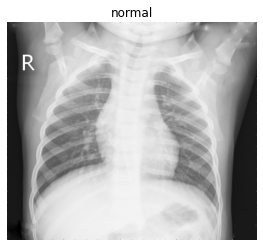

In [ ]:
# target dir with / at the end to create a path 
# target class write class we want in string 
img1 = Show_Image("/content/COVID_IEEE/","normal")

Random Image path address '['person513_virus_1030.jpeg']'
Chest Image of 'virus'class 


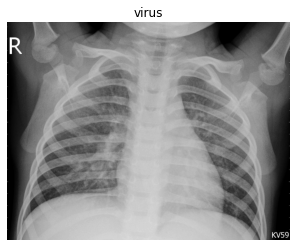

In [ ]:
img2 = Show_Image("/content/COVID_IEEE/","virus")

Random Image path address '['covid1900389.png']'
Chest Image of 'covid'class 


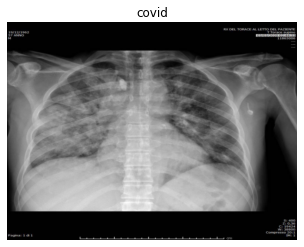

In [ ]:
img2 = Show_Image("/content/COVID_IEEE/","covid")

# Create Data and Label from Different Folders 

In [ ]:
# Create array of data and label to store all image in one array and labels
data = []
labels = []
img_size = 224


# First for covid class
covid = os.listdir("/content/COVID_IEEE/covid/") # after copy path use "/" at the end to easily join name and path of file 
for image_name_cov in covid:
  img_cov = cv2.imread("/content/COVID_IEEE/covid/"+image_name_cov,) # reading image one by one from covid class
  img_cov = cv2.resize(img_cov, (img_size,img_size)) # for applying cnn all image should be of same size so resize this acc to our choise
  data.append(img_cov)
  labels.append(0) # giving covid class label as 0 


# second for normal class
normal = os.listdir("/content/COVID_IEEE/normal/")
for image_name_nor in normal:
  img_nor = cv2.imread("/content/COVID_IEEE/normal/"+image_name_nor,)
  img_nor = cv2.resize(img_nor, (img_size,img_size))
  data.append(img_nor)
  labels.append(1) # giving normal class label as 1


# thrirdly for virus class
virus = os.listdir("/content/COVID_IEEE/virus/")
for image_name_vir in virus:
  img_vir = cv2.imread("/content/COVID_IEEE/virus/"+image_name_vir,)
  img_vir = cv2.resize(img_vir, (img_size,img_size))
  data.append(img_vir)
  labels.append(2) # giving virus class label as 2 

In [ ]:
# creating data list to array and normalizing data for cnn between 0 and 1
img_data = np.array(data)/255.0
img_labels = np.array(labels)

In [ ]:
img_data 

array([[[[0.03137255, 0.03137255, 0.03137255],
         [0.03137255, 0.03137255, 0.03137255],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.49411765, 0.49411765, 0.49411765],
         [0.49411765, 0.49411765, 0.49411765]

In [ ]:
img_labels

array([0, 0, 0, ..., 2, 2, 2])

# Split Data into Train and Test DataSet

In [ ]:
# Spliting data into train and test 
X_train, X_test, y_train, y_test = train_test_split(img_data, img_labels, test_size=0.20, random_state=0)

In [ ]:
# we have multi-class-classification problem 
# change each label into vector form or in One-Hot Encoded label 
y_train = tf.keras.utils.to_categorical(y_train, num_classes= 3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes= 3)

# BULIDING CNN MODEL

In [ ]:
#******************** BULIDING CNN MODEL **********************#

# network in sequential nature i.e. output of previous layer is input of the next layer
model = Sequential()

#---------------> Block Number 1 <--------------------#

# ************** CONV2D layer used to create feature map from image**** 
# first layer of convolution should have same size as input image size 
# beacuse this is first layer of our network oe we can say our input image 
model.add(Conv2D(input_shape = (img_size,img_size, 3), filters = 32, padding="same", kernel_size= (3,3)))
# padding same i.e. output image is same height and weight as input image bcz during conv image size reduce
#***************  Activation INTRODUCES NON-LINEARILTY IN MODEL******
model.add(Activation("relu")) # x if x > threshold else 0 " INTRODUCES NON-LINEARILTY IN MODEL "
# adding another conv black 
model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
# *************** MAXPOOL used to reduce size of feature map to make network small but deeper *****
model.add(MaxPool2D((2,2)))

#-----------------> Block Number 2 <-------------------------#
model.add(Conv2D(filters=64, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(Conv2D(filters=64, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(filters=64, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

#------------------> Block Number 3 <--------------------------#
model.add(Conv2D(filters=128, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(Conv2D(filters=128, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2))) # another adding maxpool to reduce feature map again 

#--------------------> Fully Connected layer <---------------------#

# add neural network so flatten the output comming from last layer of cnn model 
model.add(Flatten()) 
# Hidden layer Dense( layer os connected neuron ) layer  with 1024 neuron 
model.add(Dense(units=1024, activation="relu"))
# another Hidden layer with 256 neuron 
model.add(Dense(units=256, activation="relu"))
# last Hidden Layer which has same number of neuron as class label or prediction 
# we make like here 3 (covid,normal,virus) 
# for multi class classification from we use SOFTMAX activation to " " convert output into probability" "
# if we have binary class problem then we use SIGMOID 
model.add(Dense(units=3, activation="softmax"))

#-----------------------> Compile the Model <--------------------------#
# compile model i.e. """at What Parameter we want to train our model """
# here optimizer make a random guess and loss check is this guess is good or bed according to loss 
# then according to loss optimizer make another random guess and this process go on until we get good guess
# by this process we train our model to get good accuracy 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Getting Structure of Model

In [ ]:
# **************************** Getting Structure of Model **********************************#
# to know parameter and output shape of our model and get trainable and non-trainable parameters 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_8 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
activation_9 (Activation)    (None, 112, 112, 64)     

In [ ]:
len(y_train)

1458

# Train the Model
#### BATCH_SIZE : 
######batch size defines the number of samples that will be propagated through the network.

 like we have 1458 training example (len(X_train)=1458) then having 32 batch means we have 1458/32 = 45.5 ~ 46 sample to train the network in which 45 of them had 32 samples and 1 had 16 samples It requires less memory. 
 
 Since you train the network using fewer samples,the overall training procedure requires less memory.That's especially important if you are not able to fit the whole dataset in our machine's memory.

#### VALIDATION_SPLIT : 
###### Fraction of the training data to be used as validation data. 
The model will set apart this fraction of the training data, will not train on it and will evaluate the loss and any model metrics on this data at the end of each epoch. 

The validation data is selected from the last samples in the x and y data provided, before shuffling.

In [ ]:
# ************************** Train the Model ************************#
model.fit(X_train, y_train , validation_split= 0.3, epochs= 15, batch_size= 32)

Epoch 1/15
32/32 [==============================] - 13s 342ms/step - loss: 0.7773 - accuracy: 0.6088 - val_loss: 0.4584 - val_accuracy: 0.8128
Epoch 2/15
32/32 [==============================] - 9s 287ms/step - loss: 0.4129 - accuracy: 0.8520 - val_loss: 0.2664 - val_accuracy: 0.9064
Epoch 3/15
32/32 [==============================] - 9s 288ms/step - loss: 0.2560 - accuracy: 0.9059 - val_loss: 0.1970 - val_accuracy: 0.9361
Epoch 4/15
32/32 [==============================] - 9s 288ms/step - loss: 0.2252 - accuracy: 0.9225 - val_loss: 0.2027 - val_accuracy: 0.9452
Epoch 5/15
32/32 [==============================] - 9s 286ms/step - loss: 0.1432 - accuracy: 0.9490 - val_loss: 0.1870 - val_accuracy: 0.9292
Epoch 6/15
32/32 [==============================] - 9s 288ms/step - loss: 0.0967 - accuracy: 0.9667 - val_loss: 0.2022 - val_accuracy: 0.9406
Epoch 7/15
32/32 [==============================] - 9s 289ms/step - loss: 0.0701 - accuracy: 0.9765 - val_loss: 0.1868 - val_accuracy: 0.9521
Epoch

#Result Visualization 

Text(0.5, 1.0, 'Training-Validation Accuracy')

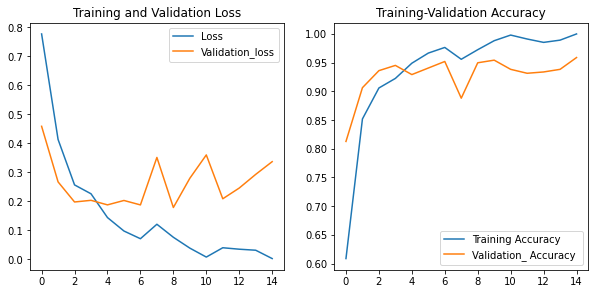

In [ ]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

# Prediction 

In [ ]:
prediction = model.predict(X_test)

# finding class with larget predicted probability using argmax of numpy 
y_pred = np.argmax(prediction, axis = 1)  # prediction using model 
y_test_orig = np.argmax(y_test, axis = 1) # original y_test


In [ ]:
print(classification_report(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       114
           1       0.95      0.95      0.95       131
           2       0.93      0.93      0.93       120

    accuracy                           0.95       365
   macro avg       0.95      0.95      0.95       365
weighted avg       0.95      0.95      0.95       365



In [ ]:
# visualize confusion_metric
label = ['covid', 'normal', 'virus']
pd.DataFrame(confusion_matrix(y_test_orig, y_pred), columns= label, index = label)


,covid,normal,virus
covid,109,2,3
normal,1,125,5
virus,3,5,112


Here accuracy = 95% which is good if this was not a health care problem.

for a health care problem, we care about false-negative rates because we need higher accuracy to get a correct prediction.

like here we see 1 person predicted as normal but actually, they have covid and similarly 3 person which is covid but our model predicts them as having a virus.

this is a serious problem like here covid infected person which classified as normal and virus can become a major source of spreading virus whereas the person which doesn't have covid and our model predict them as covid that doesn't serious as we can quarantine them but they are not the source of covid.

so to accurate them especially that which is predicted as normal and virus we use transfer learning. 

#### **transfer leraning** 
Use Weights of pre-trained models and modify them a little and used them for our model to train. This is only possible for image data not for numerical data(a fitting line that is based on someone's data).

Transfer learning is a technique for predictive modeling on a different yet similar problem that can then be reused partly or wholly to accelerate its training and eventually improve the performance of the model for the problem. 

It is the reuse of a pre-trained model on a new problem. This technique is currently becoming very popular in deep learning because it can train deep neural networks with comparatively little data and in less time. 

# Transfer Learning
**use MobileNet model's weights which is train on imagenet data and make our base model**

In [ ]:
# MobilNet as Base Model 

# include_top = False
# ------ beacuse we don't want last layer which is prediction layer
base_model = tf.keras.applications.MobileNet(input_shape=[img_size,img_size,3],
                                             weights = 'imagenet',
                                             include_top=False)
# Freeze weights :  
# ------if we don't do this our weights change during training and this will take time 
# ------and the whole purpose of using tranfer learning vanish.
# ------ beacuse purpose is that we have to use weights of pre-trained model here MobileNet don't train them
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
# *********************************ADD OUR OWN LAYER ***********************************#

# this is different now we add model in seperate brackets


# first flatten the output coming from MobileNet architecture
model = Flatten()(base_model.output) # this is different now we add model in seperate brackets

# Create Dense Layer of Neural Network same as we do in our model like 3 layer 
model = Dense(units=1024, activation='relu')(model)
model = Dense(units=512, activation='relu')(model)
model = Dense(units=256, activation='relu')(model)

# Create Prediction Layer
prediction_layer = Dense(units=3, activation='softmax')(model)

In [ ]:
# *********************** ADD OUR MODEL AND MobileNet MODEL ***********************#

# make model using Model and give input of base model (MobileNet) and output of our prediction layer(adding same layers)
model = Model(inputs = base_model.input, outputs = prediction_layer)

# compile model 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

here in summary we see this is large network with large parameters

**Trainable params: 85,592,579**

parameters that our model create 

**Non-trainable params: 3,228,864**

parameters that MobileNet model create 

In [ ]:
# ************************** Train the New Model ************************#
model.fit(X_train, y_train , validation_split= 0.3, epochs= 15, batch_size= 32)

Epoch 1/15
32/32 [==============================] - 7s 155ms/step - loss: 7.6876 - accuracy: 0.7961 - val_loss: 1.3002 - val_accuracy: 0.9315
Epoch 2/15
32/32 [==============================] - 4s 129ms/step - loss: 0.5427 - accuracy: 0.9451 - val_loss: 0.4000 - val_accuracy: 0.9589
Epoch 3/15
32/32 [==============================] - 4s 128ms/step - loss: 0.6992 - accuracy: 0.9578 - val_loss: 0.8176 - val_accuracy: 0.9452
Epoch 4/15
32/32 [==============================] - 4s 130ms/step - loss: 0.2003 - accuracy: 0.9755 - val_loss: 0.8671 - val_accuracy: 0.9589
Epoch 5/15
32/32 [==============================] - 4s 129ms/step - loss: 0.0648 - accuracy: 0.9892 - val_loss: 1.1023 - val_accuracy: 0.9452
Epoch 6/15
32/32 [==============================] - 4s 130ms/step - loss: 0.0202 - accuracy: 0.9951 - val_loss: 1.1095 - val_accuracy: 0.9566
Epoch 7/15
32/32 [==============================] - 4s 137ms/step - loss: 0.0573 - accuracy: 0.9902 - val_loss: 0.9954 - val_accuracy: 0.9475
Epoch 

Text(0.5, 1.0, 'Training-Validation Accuracy')

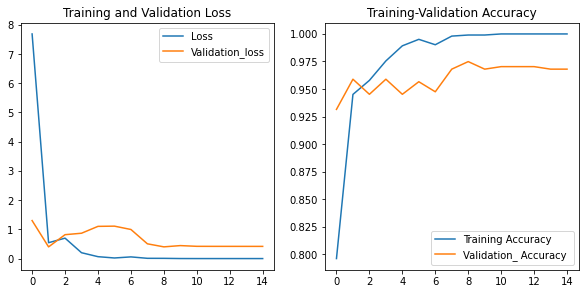

In [ ]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

**see here jump at 10th iteration after that it goes decresing**

In [ ]:
prediction = model.predict(X_test)

# finding class with larget predicted probability using argmax of numpy 
y_pred = np.argmax(prediction, axis = 1)  # prediction using model 
y_test_orig = np.argmax(y_test, axis = 1) # original y_test


In [ ]:
print(classification_report(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       114
           1       0.95      0.97      0.96       131
           2       0.96      0.96      0.96       120

    accuracy                           0.97       365
   macro avg       0.97      0.97      0.97       365
weighted avg       0.97      0.97      0.97       365



In [ ]:
# visualize confusion_metric
label = ['covid', 'normal', 'virus']
pd.DataFrame(confusion_matrix(y_test_orig, y_pred), columns= label, index = label)

,covid,normal,virus
covid,112,1,1
normal,0,127,4
virus,0,5,115


# RESULT 
**now we see here finally the wrong prediction of covid infected person classified as normal and virus are now zero.**